In [1]:
!python3 --version

Python 3.5.2


# content

[1. Play with dataset](#Play_with_dataset)

[2. Test on template matching](#Test_on_template_matching)

[3. Dataset processing](#Dataset_Processing)

- [3.1 Classify the dataset](#Classify_the_dataset)
   
- [3.1 Creat training set and validation set](#Creat_Training_set_and_Validation_set)

[4. Modelling and training](#Modelling_and_training)

- [4.1 Building the model and train it](#Building_the_model_and_train_it)

- [4.2 Analyse the training process](#Analyse_the_training_process)

[5. Model on test set](#Model_on_test_set)

- [5.1 Building the test set (sub31to40)](#Building_the_test_set_(sub31to40))

- [5.2 Test on the test set](#Test_on_the_test_set)

[6. Feature engineering](#Feature_engineering)

- [6.1 New classifier](#New_classifier)

- [6.2 New dataset](#New_dataset)

- [6.3 Train and test on new dataset](#Train_and_test_on_new_dataset)





<a id='Play_with_dataset'></a>

# 1. Play with dataset

First, before step into building the classifier, some images from sub1to10 are extracted out to test out the character of those images.

As we can see at the end of this cell, two rows of images are plotted out. The first row consists of the images showing the same face but with different illuminations. The second row shows different faces with different illuminations. With all these image samples, we can now improve some classifiers to try to figure out how we can classify these images.

Image shape is: 	 (64, 64, 3)


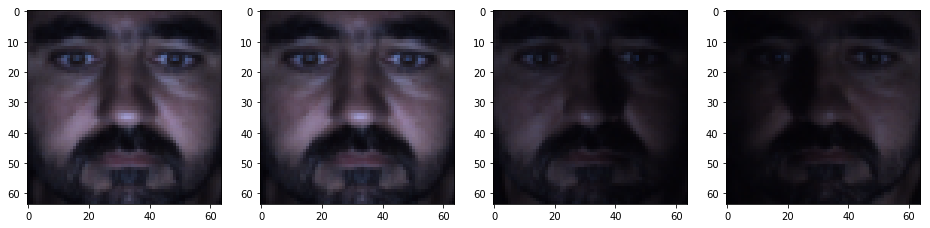

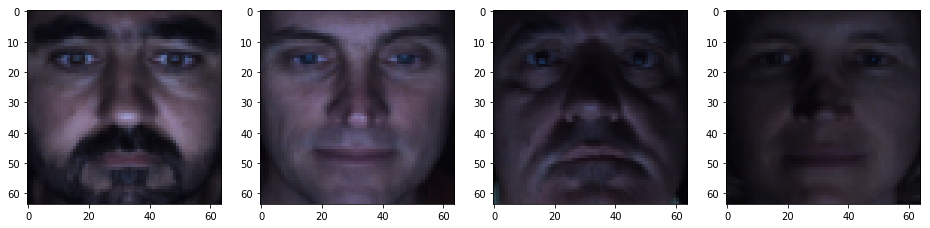

In [2]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

def GetImagePath(sub, sess, frame):
    """
    Function: get image path name according to the inputs
    """
    # read the image path
    folder_name = "sub" + str(sub) + "_session" + str(sess)
    image_path = folder_name + "/" + folder_name + "_frame" + str(frame) + ".png"
    
    return image_path

def ReadImage(image_path):
    """
    Function:
        Read and resize images with specific subname, session name and frame name.
    """
    # read the image
    image = imread(image_path)
    # resize the image
    output_size = (64, 64)
    image = resize(image, output_size)
    
    return image


# define all the sub names, session names, and frame names into np.array
sub_names_train = np.arange(1, 11)
sub_names_test = np.concatenate([np.arange(31, 39), np.array([40])], axis = -1)
session_names = np.arange(1, 3)
frame_names_train = np.arange(1, 24)
frame_names_test = np.arange(1, 25)

# image examples, for visualization and some tests
# same faces
path_example_1 = GetImagePath(sub_names_train[0], session_names[0], frame_names_train[0])
image_example_1 = ReadImage(path_example_1)
path_example_2 = GetImagePath(sub_names_train[0], session_names[1], frame_names_train[0])
image_example_2 = ReadImage(path_example_2)
path_example_3 = GetImagePath(sub_names_train[0], session_names[0], frame_names_train[10])
image_example_3 = ReadImage(path_example_3)
path_example_4 = GetImagePath(sub_names_train[0], session_names[0], frame_names_train[22])
image_example_4 = ReadImage(path_example_4)
# different faces
path_example_5 = GetImagePath(sub_names_train[1], session_names[0], frame_names_train[0])
image_example_5 = ReadImage(path_example_5)
path_example_6 = GetImagePath(sub_names_train[5], session_names[0], frame_names_train[5])
image_example_6 = ReadImage(path_example_6)
path_example_7 = GetImagePath(sub_names_test[5], session_names[0], frame_names_test[22])
image_example_7 = ReadImage(path_example_7)

# print out the shape of the image
print("Image shape is: \t", image_example_1.shape)

# same faces test
fig = plt.figure(figsize = (16, 4))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(image_example_1)
ax2.imshow(image_example_2)
ax3.imshow(image_example_3)
ax4.imshow(image_example_4)
plt.show()

# different faces test
fig = plt.figure(figsize = (16, 4))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(image_example_1)
ax2.imshow(image_example_5)
ax3.imshow(image_example_6)
ax4.imshow(image_example_7)
plt.show()


<a id='Test_on_template_matching'></a>

# 2. Test on template matching

In order to find the best template matching method, I developed several matching functions which were introduced in the lecture, namely cross-correlation(normalized), cross-correlation, convolution, and SSD. Then all image samples shown above are fed into those classifiers seperately and the corresponding scores are printed out at the end of the cell.

After comparing all those scores, I finally decided to go for the method cross-correlation(normalized) since this one is the only one gives apparent differences between same faces and different faces. And **the threshold for cross-correlation(normalized) score is set as $0.66$**.

In [3]:

def NormalizedCrossCorrelation(image1, image2):
    """
    Funtion: calculating normalized cross correlation (NCC) between two images
    """
    numerator = np.sum((image1 - np.mean(image1)) * (image2 - np.mean(image2)))
    denominator = np.sqrt(np.sum(np.square(image1 - np.mean(image1))) * \
                          np.sum(np.square(image2 - np.mean(image2))))
    return numerator / denominator

def CrossCorrelation(image1, image2):
    """
    Function: original cross correlation between two images
    """
    return np.sum((image1 - image1.mean()) * (image2 - image2.mean()))

def Convolution(image1, image2):
    """
    Funtion: calculating convolution between two images
    """
    return np.sum(np.flip((image1 - image1.mean())) * image2)

def SumSquareDifferences(image1, image2):
    """
    Funtion: calculating pixel differences between two images
    """
    return np.sum(np.square(image1 - image2))

def CompareAllTricks(image1, image2):
    """
    Function: compare the scores w.r.t 3 methods and choose the best one
    """
    a = NormalizedCrossCorrelation(image1, image2)
    b = Convolution(image1, image2)
    c = SumSquareDifferences(image1, image2)
    return [a, b, c]

# try differences betwwen correlation, convolution and squared differences
# try with same faces but different illumination
compare_example_1 = CompareAllTricks(image_example_1, image_example_2)
compare_example_2 = CompareAllTricks(image_example_1, image_example_3)
compare_example_3 = CompareAllTricks(image_example_1, image_example_4)
# try with different faces with different illumination
compare_example_4 = CompareAllTricks(image_example_1, image_example_5)
compare_example_5 = CompareAllTricks(image_example_1, image_example_6)
compare_example_6 = CompareAllTricks(image_example_1, image_example_7)

print("---------------------------------- same faces ------------------------------------")
print("NCC:{} \t \t \t Conv:{} \t SSD:{}".format(compare_example_1[0], compare_example_1[1], compare_example_1[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_2[0], compare_example_2[1], compare_example_2[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_3[0], compare_example_3[1], compare_example_3[2]))
print("------------------------------- different faces ----------------------------------")
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_4[0], compare_example_4[1], compare_example_4[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_5[0], compare_example_5[1], compare_example_5[2]))
print("NCC:{} \t Conv:{} \t SSD:{}".format(compare_example_6[0], compare_example_6[1], compare_example_6[2]))


---------------------------------- same faces ------------------------------------
NCC:1.0 	 	 	 Conv:84.91780926074851 	 SSD:0.0
NCC:0.7177882918040279 	 	 Conv:34.39739781668252 	 SSD:266.91643021914643
NCC:0.6618261099181423 	 	 Conv:27.32804301155204 	 SSD:294.1769127258746
------------------------------- different faces ----------------------------------
NCC:0.5338608734949605 	 	 Conv:60.85439800187653 	 SSD:163.69754036908876
NCC:0.2861959200424425 	 	 Conv:17.488654840536064 	 SSD:252.9331487889273
NCC:0.38768792843956684 	 Conv:20.040709458482795 	 SSD:236.74956843521716


<a id='Dataset_Processing'></a>

# 3. Dataset processing

<a id='Classify_the_dataset'></a>

## 3.1 Classify the dataset

In the following cell, each image inside the original dataset is paired with all rest images individually. Then each pair images are concatenated together along the first axis and fed into the Normalized Cross-Correlation (NCC) classifier.

Since there are totally $105570$ pairs of images, it is impossible to store them just in RAM. Therefore, a text file is created to store the processed dataset with format of each pair as:

    [image_one_path, image_two_path, NCC_score]
    
One thing worths mentioned is: in order to speed up the testing, I used a function that finds the existing datset test file. And if the text file is over $8$ MB, the system reads the text file directly without processing the original dataset again.

In [4]:
import os
from tqdm import tqdm

# setting NCC threshold according to the experiment above
def ClassifyAndSave(im1_path, im2_path):
    """
    Function: 
        find out whether two image show the same face and save the dataset
    """
    # read images
    image1 = ReadImage(im1_path)
    image2 = ReadImage(im2_path)
    # find pair scores
    NCC_score = NormalizedCrossCorrelation(image1, image2)
    
    return [im1_path, im2_path, str(NCC_score)]

def GetAllImagePathes(sub_names, session_names, frame_names):
    """
    Function: get all image pathes from the specific subsets
    """
    # subset 35 and subset 37 have no session 2
    sub_no_sess2_test = np.array([35, 37])
    # store pathes
    all_images_pathes = []
    for i in range(len(sub_names)):
        sub = sub_names[i]
        if sub in sub_no_sess2_test:
            sess_len = len(session_names) - 1
        else:
            sess_len = len(session_names)
        for j in range(sess_len):
            sess = session_names[j]
            for k in range(len(frame_names)):
                frame = frame_names[k]
                image_path = GetImagePath(sub, sess, frame)
                all_images_pathes.append(image_path)
                
    return all_images_pathes

def LoopOverEachPair(all_train_im_path):
    """
    Function:
        loop over each pair of images, find labels, and save them
    """
    # loop over each pair, define the label and save as data.txt file
    data = []
    dataset_file = open("data.txt", "w+")
    with tqdm(total=460) as pbar:
        while len(all_train_im_path) > 0:
            current_image_path = all_train_im_path[0]
            all_train_im_path.remove(current_image_path)
            for another_img_path in all_train_im_path:
                data = ClassifyAndSave(current_image_path, another_img_path)
                dataset_file.write(data[0] + "," + data[1] + "," + data[2] + "," + "\n")
            pbar.update(1)

def CreatDataset():
    """
    Function:
        create the dataset.
    """
    # get all training image pathes
    all_train_im_path = GetAllImagePathes(sub_names_train, session_names, frame_names_train)
    print("There are totally ", len(all_train_im_path), " training images.")

    # get dataset and save it into a data.txt file
    print("------------- starting storing dataset -------------")
    LoopOverEachPair(all_train_im_path)
    print("-------------- end of storing dataset --------------")
    

# read the saved data.txt, if exits and contains all data, skip the annotation part
if os.path.exists('data.txt'):
    statinfo = os.stat('data.txt')
    # get size as MB
    exist_dataset_size = statinfo.st_size / 1024 / 1024
    # total size is around 8 MB
    if exist_dataset_size > 8:
        print("------------------------ dataset already exists -------------------------")
    else:
        CreatDataset()
else:
    CreatDataset()


------------------------ dataset already exists -------------------------


After creating the dataset, we then classify the dataset according to the NCC scores. The NCC threshold is set $0.66$ as mentioned above. All image pairs scoring over $0.66$ are labelled as $1$, others $0$. 

An overview of how many image pairs are classified into different groups is printed out at the end of cell.

In [5]:

def ReadDatasetTxt(data_filename, NCC_threshold):
    """
    Function:
        read the dataset saved above, to find out some
        basical info about the dataset.
    """
    data_file = open(data_filename, "r")
    same_faces = []
    diff_faces = []
    for line in data_file:
        current_line = line.split(",")
        # find out it is same faces pair or different faces pair
        if float(current_line[2]) > NCC_threshold:
            same_faces.append([current_line[0], current_line[1], str(1)])
        else:
            diff_faces.append([current_line[0], current_line[1], str(0)])
    data_file.close()
    return same_faces, diff_faces

# setting threshold for same faces
NCC_threshold = 0.66
data_f_name = "data.txt"
same_faces, diff_faces = ReadDatasetTxt(data_f_name, NCC_threshold)

print("There are totally ", len(same_faces) + len(diff_faces), " pairs of images inside the datset,")
print("With ", len(same_faces), " pairs showing same faces,")
print("And ", len(diff_faces), " pairs showing different faces,")


There are totally  105570  pairs of images inside the datset,
With  24770  pairs showing same faces,
And  80800  pairs showing different faces,


Also, in order to visualize the results of the current classifier, a pair of images of each group is shown at the end of the cell.

Since these two pairs of images are selected randomly, one can try as many times as wanted to verify the quality of the dataset groups.

label of this pair is: 	 different faces


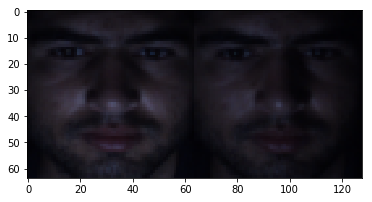

label of this pair is: 	 different faces


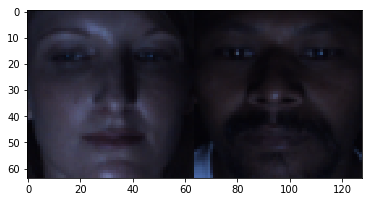

In [6]:

def PlotAndVerifyRandomPair(dataset):
    """
    Function: 
        plot random pair images with the label to verify the datset is set
    right or wrong.
    """
    # select a random index
    ind = np.random.randint(len(dataset))
    # read image pair
    img1 = ReadImage(dataset[ind][0])
    img2 = ReadImage(dataset[ind][1])
    # read label
    label = float(dataset[ind][2])
    if label > 1:
        label_show = "same face"
    else:
        label_show = "different faces"
    # plot images
    display_imgs = np.concatenate([img1, img2], axis = 1)
    print("label of this pair is: \t", label_show)
    plt.imshow(display_imgs)
    plt.show()
    
PlotAndVerifyRandomPair(same_faces)
PlotAndVerifyRandomPair(diff_faces)
    

<a id='Creat_Training_set_and_Validation_set'></a>

## 3.2 Create training set and validation set

As the question suggests, setting around $1000$ image pairs as validation set seems reasonable, which is approximatly $1$% of total image pairs. I thus, selected $1$% of same faces pairs and $1$% of different faces pairs seperately and randomly as the validation set of each group. Then, each training set and validation set w.r.t each group are combined together to form the final training set and validation set. All sets are then randomly shuffled.

The total size the training set and validation set are printed out at the end of the cell.

In [7]:
import random

def CreateTrainAndValidationSet(same_faces, diff_faces, validation_rate = 0.01):
    """
    Function:
        Shuffle the dataset and separate the dataset into training set and 
    validation set
    """
    # backup the data for shuffling
    same_faces_shuf = same_faces
    diff_faces_shuf = diff_faces
    # define number of validation data w.r.t each class
    same_validate_num = int(len(same_faces) * validation_rate)
    diff_validate_num = int(len(diff_faces) * validation_rate)
    # get shuffled data
    random.shuffle(same_faces_shuf)
    random.shuffle(diff_faces_shuf)
    # define training and validation set
    valid_set = same_faces_shuf[:same_validate_num] + diff_faces_shuf[:diff_validate_num]
    train_set = same_faces_shuf[same_validate_num:] + diff_faces_shuf[diff_validate_num:]
    # shuffle the training set and validation set again
    random.shuffle(train_set)
    random.shuffle(valid_set)
    return train_set, valid_set

train_set_pathes, valid_set_pathes = CreateTrainAndValidationSet(same_faces, diff_faces)

print("Size of training set is: \t", len(train_set_pathes))
print("Size of validation set is: \t", len(valid_set_pathes))


Size of training set is: 	 104516
Size of validation set is: 	 1054


<a id='Modelling_and_training'></a>

# 4 Modelling and training


For the validation set, since it has only $1055$ images sized ($128$, $64$, $3$), I prepared all the image pairs and store them into the RAM at very beginning. 

In [8]:

def GetInputAndOutput(data_pathes):
    """
    Function:
        get all input data and labels
    """
    inputs = []
    labels = []
    # get every data in each batch
    for i in range(len(data_pathes)):
        current_data = data_pathes[i]
        # read images (resized)
        img1 = ReadImage(current_data[0])
        img2 = ReadImage(current_data[1])
        # concatenate images
        img_concat = np.concatenate([img1, img2], axis = 0)
        # reshape input data
        each_input = img_concat.reshape((-1,))
        # get label as one hot format
        label_ind = int(current_data[2])
        label = np.zeros((2,)).astype(np.float32)
        label[label_ind] = 1.
        # orgnizing input and output
        inputs.append(each_input)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return (inputs, labels)

# get validation set first
validation_set = GetInputAndOutput(valid_set_pathes)
print(validation_set[0].shape)


(1054, 24576)


<a id='Building_the_model_and_train_it'></a>

## 4.1 Building the model and train it

The training set contains thouthands of images, so it is impossible to read them and use them at the same time. Therefore, I defined a data generator before building the model. The generator basically reads each pair of images on batch size, concatenates them, labels the same face class as **[0.0, 1.0]** and the different face class as **[1.0, 0.0]**, then feed into the model.

The model structure can be described as,

    [batch, 128 * 64 * 3] -> [batch, 256] -> [batch, 64] -> [batch, 2]

Other parameters are set as:

- activation function of hidden layers: "relu";
- gating function: "softmax";
- optimizer: "Adam";
- learning rate: $0.01$;
- batch size: $256$;
- epoches: $2$ (because the training process is really slow);

The loss value and validation accuracy are checked at each batch. And finally, all check points are saved into numpy array for further usage.

In [9]:
##### set specific gpu #####
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
##### start other dependencies #####
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def InputAndOutputGenerator(data_pathes, batch_size = 256):
    """
    Function:
        Since when transfer into images, dataset is too big to read it all at once, a generator
    is created to generate the data according to the batch_size
    """
    # get number of batches
    num_batch = len(data_pathes) // batch_size
    for batch_id in range(num_batch):
        # get batch data
        data_path_batch = data_pathes[batch_id*batch_size: (batch_id+1)*batch_size]
        batch_inputs = []
        batch_labels = []
        # get every data in each batch
        for i in range(len(data_path_batch)):
            current_data = data_path_batch[i]
            # read images (resized)
            img1 = ReadImage(current_data[0])
            img2 = ReadImage(current_data[1])
            # concatenate images
            img_concat = np.concatenate([img1, img2], axis = 0)
            # reshape input data
            each_input = img_concat.reshape((-1,))
            # get label as one hot format
            label_ind = int(current_data[2])
            label = np.zeros((2,)).astype(np.float32)
            label[label_ind] = 1.
            # orgnizing input and output
            batch_inputs.append(each_input)
            batch_labels.append(label)
        batch_inputs = np.array(batch_inputs)
        batch_labels = np.array(batch_labels)
        yield (batch_inputs, batch_labels)

def MLPModel():
    """
    Building the MLP model
    """
    model = Sequential()
    # structure: (batch, 128*64*3) -> (batch, 256) -> (batch, 64) -> (batch, 2)
    model.add(Dense(units = 256, activation = "relu", input_dim = 128 * 64 * 3))
    model.add(Dense(units = 64, activation = "relu"))
    model.add(Dense(units = 2, activation = "softmax"))
    # using cross entropy as loss and adam as optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr = 1e-3),
                  metrics=['accuracy'])
    return model

# define model.fit_generator parameters.
batch_size = 256
num_batch_train = len(train_set_pathes) // batch_size

# gpu memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# get model
model = MLPModel()

# training and validating on each batch
epoches = 2
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
for each_epoch in tqdm(range(epoches)):
    count = 0
    for data_train in InputAndOutputGenerator(train_set_pathes, batch_size):
        count += 1
        train_los_metr =  model.train_on_batch(data_train[0], data_train[1])
        val_los_metr = model.evaluate(validation_set[0], validation_set[1], verbose=0)
        train_loss.append(train_los_metr[0])
        train_acc.append(train_los_metr[1])
        valid_loss.append(val_los_metr[0])
        valid_acc.append(val_los_metr[1])
        print("current_batch: {}/{}, train_loss: {}, train_acc: {}, valid_loss: {}, valid_acc: {}"\
              .format(count, num_batch_train, train_los_metr[0], train_los_metr[1], val_los_metr[0], val_los_metr[1]), end = "\r")

np.save("original_MLP_trainloss.npy", np.array(train_loss))
np.save("original_MLP_trainacc.npy", np.array(train_acc))
np.save("original_MLP_validloss.npy", np.array(valid_loss))
np.save("original_MLP_validacc.npy", np.array(valid_acc))


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

 50%|█████     | 1/2 [36:54<36:54, 2214.66s/it]

100%|██████████| 2/2 [1:13:44<00:00, 2212.08s/it]

<a id='Analyse_the_training_process'></a>

## 4.2 Analyse the training process

In order to visualize the process, all saved checked points are called and the corresponding loss value and validation accuracy are plotted out at the end of the cell.

Apparently, the model learnt very fast at the beginning, then slowed down the learning speed. And finally the accuracy reached about $90$% on the validation set. This basically illustrates the model can be trained well on the given dataset.

The accuracy of validation set: 	 0.9089184060721063


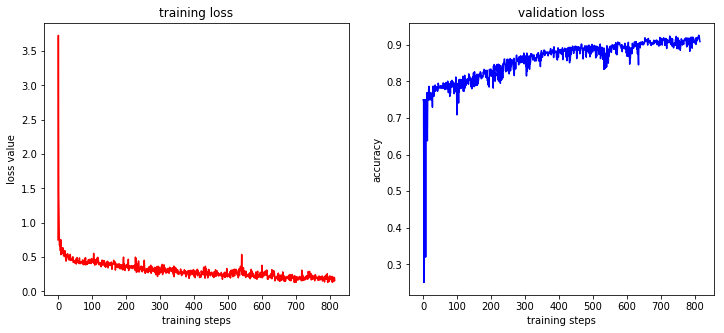

In [10]:

def SparseData(x_in, y_in, window = 25, order = 1):
    """
    Function:
        Smooth the plot.
    """
    x = x_in
    y = savgol_filter(y_in, window, order)
    return x, y

train_los = np.load("original_MLP_trainloss.npy")
train_acc = np.load("original_MLP_trainacc.npy")
valid_los = np.load("original_MLP_validloss.npy")
valid_acc = np.load("original_MLP_validacc.npy")

print("The accuracy of validation set: \t", valid_acc[-1])

display_steps = int(1 * len(train_los))
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(train_los[:display_steps], 'r')
ax1.set_title("training loss")
ax1.set_xlabel("training steps")
ax1.set_ylabel("loss value")
ax2.plot(valid_acc[:display_steps], 'b')
ax2.set_title("validation loss")
ax2.set_xlabel("training steps")
ax2.set_ylabel("accuracy")
plt.show()



<a id='Model_on_test_set'></a>

# 5. Model on test set

<a id='Building_the_test_set_(sub31to40)'></a>

## 5.1 Building the test set (sub31to40)

First, I create the test set with the same principle as I did on the training set. But this time, the ground truth labels are usded to label the test set.

Here, the ground truth is: **when two images have the same subset name, they are showing the same faces. Otherwise, they are showing different faces**. With this, the ground truth of the test set could be easily derived.

Also, the test set is written into a text file with the same format as the training set.

In [11]:
import re

def TestAnnotate(img1_path, img2_path):
    """
    Function:
        Get the annotation of the test set.
    Principle:
        If two images belong to the same subset, they are showing the same face.
    """
    # find the subset number
    img1_sub_searcher = re.search("\d", img1_path)
    img2_sub_searcher = re.search("\d", img2_path)
    img1_sub_ind = int(img1_path[img1_sub_searcher.start(): img1_sub_searcher.start()+2])
    img2_sub_ind = int(img2_path[img2_sub_searcher.start(): img1_sub_searcher.start()+2])
    # compare subset number
    if img1_sub_ind == img2_sub_ind:
        label = 1
    else:
        label = 0
    return [img1_path, img2_path, str(label)]
    

def TestSetLoop(all_test_im_path):
    """
    Function:
        loop over each pair of test images, define labels, and save them
    """
    data = []
    dataset_file = open("data_test.txt", "w+")
    with tqdm(total=len(all_test_im_path)) as pbar:
        while len(all_test_im_path) > 0:
            current_image_path = all_test_im_path[0]
            all_test_im_path.remove(current_image_path)
            for another_img_path in all_test_im_path:
                data = TestAnnotate(current_image_path, another_img_path)
                dataset_file.write(data[0] + "," + data[1] + "," + data[2] + "," + "\n")
            pbar.update(1)

def CreateTestSet():
    """
    Function:
        create the test set file
    """
    all_test_im_path = GetAllImagePathes(sub_names_test, session_names, frame_names_test)
    print("There are totally ", len(all_test_im_path), " testing images.")

    # get dataset and save it into a data.txt file
    print("------------- starting storing dataset (test) -------------")
    TestSetLoop(all_test_im_path)
    print("-------------- end of storing dataset (test) --------------")
    
    
# read the saved data_test.txt, if exits and contains all data, skip the annotation part
if os.path.exists('data_test.txt'):
    testinfo = os.stat('data_test.txt')
    # get size as MB
    exist_testset_size = testinfo.st_size / 1024 / 1024
    # total size is around 6 MB
    if exist_testset_size > 6:
        print("------------------------ dataset already exists -------------------------")
    else:
        CreateTestSet()
else:
    CreateTestSet()


------------------------ dataset already exists -------------------------


<a id='Test_on_the_test_set'></a>

## 5.2 Test on the test set

Since the test set is also large, generator is also used in this case to create batch data at each time.

The final result on the test set could be shown at the end of the cell.

A small **conclusion** would be,

1. Although it seems the model learnt well on the training set, it still cannot perform well on the classification task. The possible reason could be the classifier, which, in this case, is NCC. Since NCC cannot distinguishly classify the images, the training and validation set are extremely noisy. This leads to the bad performance of the model.

2. Since deep learning requires relative good quality of the dataset. This means the distribution of the dataset can be noisy but with the right expectation. However, in this case, the original NCC classifier deviate the distribution to the opposite way (contains too much false information). This could be improved by more pre-proessing skills.

3. The speed of the prediction is relative good because the model itself is not complex with limited number of parameters.

In [12]:
import time

def ReadDatasetTxt(data_filename, NCC_threshold):
    """
    Function:
        read the dataset saved above, to find out some
        basical info about the dataset.
    """
    data_file = open(data_filename, "r")
    same_faces = []
    diff_faces = []
    for line in data_file:
        current_line = line.split(",")
        # find out it is same faces pair or different faces pair
        if float(current_line[2]) > NCC_threshold:
            same_faces.append([current_line[0], current_line[1], str(1)])
        else:
            diff_faces.append([current_line[0], current_line[1], str(0)])
    data_file.close()
    return same_faces, diff_faces

def ReadShuffleTestData(data_filename):
    """
    Function:
        read the shuffle test data
    """
    data_file = open(data_filename, "r")
    all_data = []
    for line in data_file:
        current_line = line.split(",")
        all_data.append(current_line)
    random.shuffle(all_data)
    return all_data

def TestOnBatch(test_set):
    """
    Function:
        Validate the model on the test set.
    """
    batch_count = 0
    # same batch size as used before
    batch_size = 512
    total_batch = len(test_set) // batch_size
    total_time = []
    # test on batch since the dataset size is too big
    for data_test in InputAndOutputGenerator(test_set, batch_size):
        start_time = time.time()
        test_result =  model.test_on_batch(data_test[0], data_test[1])
        print("current batch: {}/{}, test batch result: {}".format(batch_count, total_batch, \
                                                                   test_result), end="\r")
        time_duration = (time.time() - start_time) / batch_size
        total_time.append(time_duration)
        batch_count += 1
    print("---------------------- test results ---------------------------")
    average_time = sum(total_time) / total_batch
    return test_result[1], average_time

# specify test data
data_test_name = "data_test.txt"
# shuffle all data
test_set = ReadShuffleTestData(data_test_name)
# get same face images and different faces images seperately
test_same, test_diff = ReadDatasetTxt(data_test_name, 0.5)

# print out the size of the sets
print("There are totally ", len(test_set), " pairs of images inside the test set,")
print("With ", len(test_same), " pairs showing same faces,")
print("And ", len(test_diff), " pairs showing different faces,")

print("\n")
test_result_same, time_result_same = TestOnBatch(test_same)
print("Accuracy of the same face data:\t", test_result_same, " average prediction time:\t", time_result_same)
test_result_diff, time_result_diff = TestOnBatch(test_diff)
print("Accuracy of the different face data:\t", test_result_diff, " average prediction time:\t", time_result_diff)
test_result_all, time_result_all = TestOnBatch(test_set)
print("Accuracy of the all data:\t", test_result_all, " average prediction time:\t", time_result_all)


There are totally  73536  pairs of images inside the test set,
With  8448  pairs showing same faces,
And  65088  pairs showing different faces,


---------------------- test results ---------------------------]
Accuracy of the same face data:	 0.6640625  average prediction time:	 0.00012595829321071506
---------------------- test results ---------------------------62]]
Accuracy of the different face data:	 0.19726562  average prediction time:	 0.0001278635349095337
---------------------- test results ---------------------------88]
Accuracy of the all data:	 0.38867188  average prediction time:	 0.00013088566492070684


<a id='Feature_engineering'></a>

# 6. Feature Engineering

<a id='New_classifier'></a>

## 6.1 New classifier

After testing on several traditional image procesing skills, I finally settled down on the following process:

1. Grayscale the image.

2. Apply histogram equalization on the image to emphasize the contrast.

3. Use Sobel kernel to extract the gradient of the image.

With all the steps described above, the outline of the face is finally extracted out. Same image samples which were used in the first section are used again for the comparison. Images are plotted at the end of the cell.

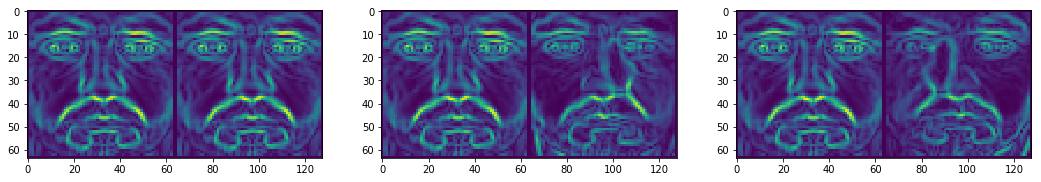

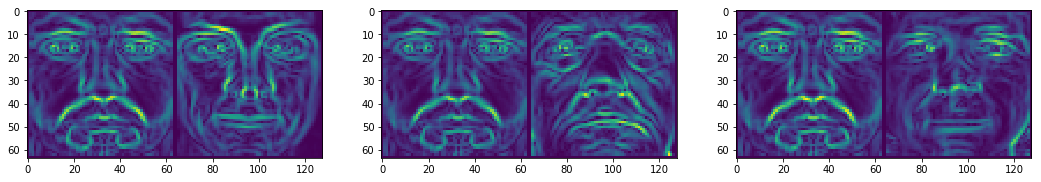

In [13]:
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import roberts, sobel

def GrayGradient(img):
    """
    Function: 
        Find the gradient of the image after grayscaled
    """
    gray_img = rgb2gray(img)
    return sobel(gray_img)

def GrayHistGradient(img):
    """
    Function:
        Apply histogram equalization on the grayscaled image first,
    then find the gradient.
    """
    gray_img = rgb2gray(img)
    gray_hist = equalize_hist(gray_img)
    return sobel(gray_hist)

# try image processing skills on all the example images
image_processsample_1 = GrayHistGradient(image_example_1)
image_processsample_2 = GrayHistGradient(image_example_2)
image_processsample_3 = GrayHistGradient(image_example_3)
image_processsample_4 = GrayHistGradient(image_example_4)
image_processsample_5 = GrayHistGradient(image_example_5)
image_processsample_6 = GrayHistGradient(image_example_6)
image_processsample_7 = GrayHistGradient(image_example_7)

# try with same faces but different illumination
sample1 = np.concatenate([image_processsample_1, image_processsample_2], axis = 1)
sample2 = np.concatenate([image_processsample_1, image_processsample_3], axis = 1)
sample3 = np.concatenate([image_processsample_1, image_processsample_4], axis = 1)
# try with different faces with different illumination
sample4 = np.concatenate([image_processsample_1, image_processsample_5], axis = 1)
sample5 = np.concatenate([image_processsample_1, image_processsample_6], axis = 1)
sample6 = np.concatenate([image_processsample_1, image_processsample_7], axis = 1)

# show results of the same faces
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(sample1)
ax2.imshow(sample2)
ax3.imshow(sample3)
plt.show()

# show results of different faces
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(sample4)
ax2.imshow(sample5)
ax3.imshow(sample6)
plt.show()


After pre-process the images, each pair are sent back to the Normalized Cross-Correlation(NCC) again to find out the scores of the image are improved or not.

Apparently, the results are improved a lot. We can immediately tell there exists a threshold which devides the same face class and different face class.

In [14]:
# try differences betwwen correlation, convolution and squared differences
# try with same faces but different illumination
compare_process_1 = CompareAllTricks(image_processsample_1, image_processsample_2)
compare_process_2 = CompareAllTricks(image_processsample_1, image_processsample_3)
compare_process_3 = CompareAllTricks(image_processsample_1, image_processsample_4)
# try with different faces with different illumination
compare_process_4 = CompareAllTricks(image_processsample_1, image_processsample_5)
compare_process_5 = CompareAllTricks(image_processsample_1, image_processsample_6)
compare_process_6 = CompareAllTricks(image_processsample_1, image_processsample_7)

print("---------------------------------- same faces ------------------------------------")
print("NCC:{} \t \t \t Conv:{} \t SSD:{}".format(compare_process_1[0], compare_process_1[1], compare_process_1[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_process_2[0], compare_process_2[1], compare_process_2[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_process_3[0], compare_process_3[1], compare_process_3[2]))
print("------------------------------- different faces ----------------------------------")
print("NCC:{} \t Conv:{} \t \t SSD:{}".format(compare_process_4[0], compare_process_4[1], compare_process_4[2]))
print("NCC:{} \t \t Conv:{} \t \t SSD:{}".format(compare_process_5[0], compare_process_5[1], compare_process_5[2]))
print("NCC:{} \t Conv:{} \t SSD:{}".format(compare_process_6[0], compare_process_6[1], compare_process_6[2]))

---------------------------------- same faces ------------------------------------
NCC:1.0 	 	 	 Conv:10.299337974386301 	 SSD:0.0
NCC:0.6437321093741377 	 	 Conv:5.894110549158487 	 SSD:27.959761674595217
NCC:0.5406864598272316 	 	 Conv:6.228113642589015 	 SSD:35.20275397658082
------------------------------- different faces ----------------------------------
NCC:0.33668983078137077 	 Conv:8.2089805868561 	 	 SSD:52.75581744084407
NCC:0.1830068066905664 	 	 Conv:6.92714501030044 	 	 SSD:71.95477768337645
NCC:0.28816781072249525 	 Conv:5.101868966695818 	 SSD:51.75210315429355


<a id='New_dataset'></a>

## 6.2 New dataset

As the same, I transferred all the original dataset into a text file.

What is different is that, for each image, instead of reading the image directly, pre-processing described above is applied into the whole dataset production.

In [15]:

# applying image pre-processing to the new classifier
def NewClassifier(im1_path, im2_path):
    """
    Function: 
        Apply pre-processing before cross-correlation
    """
    # read images
    image1 = GrayHistGradient(ReadImage(im1_path))
    image2 = GrayHistGradient(ReadImage(im2_path))
    # find pair scores
    NCC_score = NormalizedCrossCorrelation(image1, image2)
    
    return [im1_path, im2_path, str(NCC_score)]

def NewDatasetLoop(all_train_im_path):
    """
    Function:
        loop over each pair of images, classify them with new trick.
    """
    # loop over each pair, define the label and save as data.txt file
    data = []
    dataset_file = open("data_new.txt", "w+")
    with tqdm(total=460) as pbar:
        while len(all_train_im_path) > 0:
            current_image_path = all_train_im_path[0]
            all_train_im_path.remove(current_image_path)
            for another_img_path in all_train_im_path:
                data = NewClassifier(current_image_path, another_img_path)
                dataset_file.write(data[0] + "," + data[1] + "," + data[2] + "," + "\n")
            pbar.update(1)

def CreatNewDataset():
    """
    Function:
        create the dataset.
    """
    # get all training image pathes
    all_train_im_path = GetAllImagePathes(sub_names_train, session_names, frame_names_train)
    print("There are totally ", len(all_train_im_path), " training images.")

    # get dataset and save it into a data.txt file
    print("------------- starting storing dataset -------------")
    NewDatasetLoop(all_train_im_path)
    print("-------------- end of storing dataset --------------")
    

# read the saved data.txt, if exits and contains all data, skip the annotation part
if os.path.exists('data_new.txt'):
    statinfo_new = os.stat('data_new.txt')
    # get size as MB
    exist_new_dataset_size = statinfo_new.st_size / 1024 / 1024
    # total size is around 8 MB
    if exist_new_dataset_size > 8:
        print("------------------------ dataset already exists -------------------------")
    else:
        CreatNewDataset()
else:
    CreatNewDataset()

------------------------ dataset already exists -------------------------


According to the NCC score samples on those pre-processed images, a new NCC threshold is set as $0.53$. And the size of the each group are shown at the end.

In [16]:
# setting threshold for same faces
new_NCC_threshold = 0.53
new_dataset_name = "data_new.txt"
new_same_faces, new_diff_faces = ReadDatasetTxt(new_dataset_name, new_NCC_threshold)

print("There are totally ", len(new_same_faces) + len(new_diff_faces), " pairs of images inside the datset,")
print("With ", len(new_same_faces), " pairs showing same faces,")
print("And ", len(new_diff_faces), " pairs showing different faces,")

There are totally  105570  pairs of images inside the datset,
With  10010  pairs showing same faces,
And  95560  pairs showing different faces,


Also, all validation set are firstly created due to the small size of the set.

One thing worths mentioned is that, since we apply the pre-process on the images, the size immediately shrink to the $1/3$ of the original size, which speed up the whole process significantly.

In [17]:
train_new_pathes, valid_new_pathes = CreateTrainAndValidationSet(new_same_faces, new_diff_faces)

print("Size of training set is: \t", len(train_new_pathes))
print("Size of validation set is: \t", len(valid_new_pathes))

def GetInputAndOutputNew(data_pathes):
    """
    Function:
        get all input data and labels
    """
    inputs = []
    labels = []
    # get every data in each batch
    for i in range(len(data_pathes)):
        current_data = data_pathes[i]
        # read images (resized)
        img1 = GrayHistGradient(ReadImage(current_data[0]))
        img2 = GrayHistGradient(ReadImage(current_data[1]))
        # concatenate images
        img_concat = np.concatenate([img1, img2], axis = 0)
        # reshape input data
        each_input = img_concat.reshape((-1,))
        # get label as one hot format
        label_ind = int(current_data[2])
        label = np.zeros((2,)).astype(np.float32)
        label[label_ind] = 1.
        # orgnizing input and output
        inputs.append(each_input)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return (inputs, labels)

# get validation set first
validation_set_new = GetInputAndOutputNew(valid_new_pathes)
print(validation_set_new[0].shape)

Size of training set is: 	 104515
Size of validation set is: 	 1055
(1055, 8192)


<a id='Train_and_test_on_new_dataset'></a>

## 6.3 Train and test on new dataset

The training data generator is modified a little bit with adding the pre-process to the images. As experiments show, this small change extremely speed up the training process since the input of the model shrink the size to $1/3$ of its original size.

Also, except the input size, all other parameters are set the same values as the original model I built in order to compare the performance of different classfiers.

In [18]:

def InputAndOutputGeneratorNew(data_pathes, batch_size):
    """
    Function:
        Since when transfer into images, dataset is too big to read it all at once, a generator
    is created to generate the data according to the batch_size
    """
    # get number of batches
    num_batch = len(data_pathes) // batch_size
    for batch_id in range(num_batch):
        # get batch data
        data_path_batch = data_pathes[batch_id*batch_size: (batch_id+1)*batch_size]
        batch_inputs = []
        batch_labels = []
        # get every data in each batch
        for i in range(len(data_path_batch)):
            current_data = data_path_batch[i]
            # read images (resized)
            img1 = GrayHistGradient(ReadImage(current_data[0]))
            img2 = GrayHistGradient(ReadImage(current_data[1]))
            # concatenate images
            img_concat = np.concatenate([img1, img2], axis = 0)
            # reshape input data
            each_input = img_concat.reshape((-1,))
            # get label as one hot format
            label_ind = int(current_data[2])
            label = np.zeros((2,)).astype(np.float32)
            label[label_ind] = 1.
            # orgnizing input and output
            batch_inputs.append(each_input)
            batch_labels.append(label)
        batch_inputs = np.array(batch_inputs)
        batch_labels = np.array(batch_labels)
        yield (batch_inputs, batch_labels)
        
def NewMLPModel():
    """
    Building the MLP model
    """
    model = Sequential()
    # structure: (batch, 128*64) -> (batch, 1024) -> (batch, 256) -> (batch, 64) -> (batch, 10)
    model.add(Dense(units = 256, activation = "relu", input_dim = 128 * 64))
    model.add(Dense(units = 64, activation = "relu"))
    model.add(Dense(units = 2, activation = "softmax"))
    # using cross entropy as loss and adam as optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr = 1e-3),
                  metrics=['accuracy'])
    return model

As usual, the loss value and validation accuracy are stored at each batch, then stored into numpy arrays at the end of the cell.

In [19]:
##### set specific gpu #####
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
##### start other dependencies #####
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# define model.fit_generator parameters.
batch_size = 256
num_batch_train_new = len(train_new_pathes) // batch_size

# gpu memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# get model
model_new = NewMLPModel()

# training and validating on each batch
epoches = 2
train_loss_new = []
train_acc_new = []
valid_loss_new = []
valid_acc_new = []
for each_epoch in tqdm(range(epoches)):
    count = 0
    for data_train_new in InputAndOutputGeneratorNew(train_new_pathes, batch_size):
        count += 1
        train_los_metr_new =  model_new.train_on_batch(data_train_new[0], data_train_new[1])
        val_los_metr_new = model_new.evaluate(validation_set_new[0], validation_set_new[1], verbose=0)
        train_loss_new.append(train_los_metr_new[0])
        train_acc_new.append(train_los_metr_new[1])
        valid_loss_new.append(val_los_metr_new[0])
        valid_acc_new.append(val_los_metr_new[1])
        print("current_batch: {}/{}, train_loss: {}, train_acc: {}, valid_loss: {}, valid_acc: {}"\
              .format(count, num_batch_train_new, train_los_metr_new[0], train_los_metr_new[1], \
                      val_los_metr_new[0], val_los_metr_new[1]), end = "\r")

np.save("new_MLP_trainloss.npy", np.array(train_loss_new))
np.save("new_MLP_trainacc.npy", np.array(train_acc_new))
np.save("new_MLP_validloss.npy", np.array(valid_loss_new))
np.save("new_MLP_validacc.npy", np.array(valid_acc_new))


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [38:45<38:45, 2325.52s/it]

100%|██████████| 2/2 [1:17:30<00:00, 2325.04s/it]

Similar plots are plotted out for visualizing the whole training process.

It could be seen that, the loss function converges faster than the original model, and the accuracy goes higher than before. This means the new pre-process skill effectively improves the training process.

The accuracy of validation set: 	 0.9943127962085309


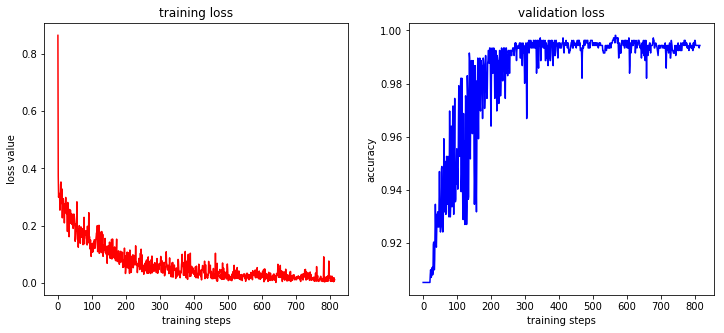

In [20]:

train_los_new = np.load("new_MLP_trainloss.npy")
train_acc_new = np.load("new_MLP_trainacc.npy")
valid_los_new = np.load("new_MLP_validloss.npy")
valid_acc_new = np.load("new_MLP_validacc.npy")

print("The accuracy of validation set: \t", valid_acc_new[-1])

display_steps = int(1 * len(train_los_new))
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(train_los_new[:display_steps], 'r')
ax1.set_title("training loss")
ax1.set_xlabel("training steps")
ax1.set_ylabel("loss value")
ax2.plot(valid_acc_new[:display_steps], 'b')
ax2.set_title("validation loss")
ax2.set_xlabel("training steps")
ax2.set_ylabel("accuracy")
plt.show()


Same tests on the same test set are also conducted below. After comparing the current results with previous one, a brief conclusion could be drawn as below.

1. The outline extraction of the face feature before the MLP improves the classification task.

2. As mentioned above, the new process relieve the huge mislabelling gap between the training data and the ground truth data, which is the main reason it improves the result a lot.

3. The speed is relatively higher than before. This is because the input size is effectively shrunk, which means the model itself has to deal with less data than before.

4. Overall, the new pre-process improves not only the performance, but also the speed of the prediction of the model.

In [21]:

def TestOnBatchNew(test_set):
    """
    Function:
        Validate the model on the test set.
    """
    batch_count = 0
    # same batch size as used before
    batch_size = 512
    total_batch = len(test_set) // batch_size
    total_time = []
    # test on batch since the dataset size is too big
    for data_test in InputAndOutputGeneratorNew(test_set, batch_size):
        start_time = time.time()
        test_result =  model_new.test_on_batch(data_test[0], data_test[1])
        print("current batch: {}/{}, test batch result: {}".format(batch_count, total_batch, \
                                                                   test_result), end="\r")
        time_duration = (time.time() - start_time) / batch_size
        total_time.append(time_duration)
        batch_count += 1
    print("---------------------- test results ---------------------------")
    average_time = sum(total_time) / total_batch
    return test_result[1], average_time

test_new_same, time_new_same = TestOnBatchNew(test_same)
print("Accuracy of the same face data:\t", test_new_same, " average prediction time:\t", time_new_same)
test_new_diff, time_new_diff = TestOnBatchNew(test_diff)
print("Accuracy of the different face data:\t", test_new_diff, " average prediction time:\t", time_new_diff)
test_new_all, time_new_all = TestOnBatchNew(test_set)
print("Accuracy of the all data:\t", test_new_all, " average prediction time:\t", time_new_all)


---------------------- test results ---------------------------]]
Accuracy of the same face data:	 0.9394531  average prediction time:	 3.87453765142709e-05
---------------------- test results ---------------------------2]]]
Accuracy of the different face data:	 0.25195312  average prediction time:	 3.6916856866652573e-05
---------------------- test results ---------------------------25]
Accuracy of the all data:	 0.23828125  average prediction time:	 3.757103105316629e-05
